In [18]:
!pip install gym
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-opengl is already the newest version (3.1.0+dfsg-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.3).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1005'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1005'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [0]:
import gym

In [0]:
env = gym.make("CartPole-v0")

In [0]:
import torch
import torch.nn as n
import torch.optim as op
import torch.nn.functional as f

In [0]:
observationsize=env.observation_space.shape[0]

In [24]:
observationsize

4

In [0]:
hiddensize=128
batchsize=16
percent=70
from collections import namedtuple

In [0]:
class net(n.Module):
  def __init__(self,obs_size,actionsize,nactions):
    super().__init__()
    self.fc1=n.Linear(obs_size,hiddensize)
    self.fc2=n.Linear(hiddensize,actionsize)
  
  def forward(self,x):
    out=f.relu(self.fc1(x))
    out=self.fc2(out)
    return out

In [0]:
from collections import namedtuple

In [0]:
episode1=namedtuple("episode",field_names=['reward','steps'])

In [0]:
e1=episode1(1,12)

In [0]:
episodestep=namedtuple("episodestep",field_names=['observation','action'])

In [31]:
e1.reward

1

In [0]:
import numpy as np
import torch
import torch.nn as n
import torch.optim as op
import torch.nn.functional as f

In [0]:
def iterate_batches(env,net,batchsize):
  batch=[]
  episodereward=0
  episodesteps=[]
  obs=env.reset()
  sm=n.Softmax(dim=1)
  while True:
    obs_v=torch.FloatTensor([obs])
    acs_probs_v=net(obs_v)
    acs_probs=sm(acs_probs_v)
    acs_probs=acs_probs.data.numpy()[0]
    act=np.random.choice(len(acs_probs),p=acs_probs)
    #print(action)
    nextobs,reward,isdone,_=env.step(act)
    episodereward+=reward
    episodesteps.append(episodestep(observation=obs,action=act))
    if isdone:
      batch.append(episode1(reward=episodereward,steps=episodesteps))
      episodereward=0
      episodesteps=[]
      nextobs=env.reset()
      if len(batch)==batchsize:
        yield batch
        batch=[]
    obs=nextobs

In [0]:
def filter_batch(batch,percentile):
  rewards=list(map(lambda s:s.reward,batch))
  rewards_bound=np.percentile(rewards,percentile)
  rewardsmean=float(np.mean(rewards))
  train_obs=[]
  train_act=[]
  #print(batch[0])
  for example in batch:
    if example.reward<rewards_bound:
      continue
    #print(example.steps)
    train_obs.extend(map(lambda x:x.observation,example.steps))
    train_act.extend(map(lambda x:x.action,example.steps))
  
  train_obs_v=torch.FloatTensor(train_obs)
  train_act_v=torch.LongTensor(train_act)
  return train_obs_v,train_act_v,rewards_bound,rewardsmean


In [0]:
env=gym.make("CartPole-v0")

In [0]:
obssize=env.observation_space.shape[0]
n_actions=env.action_space.n

In [0]:
net1=net(obssize,2,4)

In [75]:
env.action_space.n

2

In [58]:
sum(x.numel() for x in net1.parameters())

898

In [0]:
objective=n.CrossEntropyLoss()
optimizer=op.Adam(net1.parameters(),lr=0.001)

In [83]:
count=0
for iter_no,batch in enumerate(iterate_batches(env,net1,batchsize)):
  obs_v,acts_v,rewards_b,reward_m=filter_batch(batch,70)
  optimizer.zero_grad()
  action_scores_v=net1(obs_v)
  loss_v=objective(action_scores_v,acts_v)
  loss_v.backward()
  optimizer.step()
  print("loss:-",loss_v.item()," reward mean:-",reward_m," reward bound:-",rewards_b)
  count+=1
  if count==500:
    break

loss:- 0.6843963861465454  reward mean:- 22.9375  reward bound:- 24.0
loss:- 0.6894940137863159  reward mean:- 21.5  reward bound:- 22.5
loss:- 0.6976339817047119  reward mean:- 20.0625  reward bound:- 23.5
loss:- 0.6888865232467651  reward mean:- 22.0  reward bound:- 21.0
loss:- 0.691582202911377  reward mean:- 21.6875  reward bound:- 26.0
loss:- 0.6839491128921509  reward mean:- 25.0  reward bound:- 31.5
loss:- 0.6856576800346375  reward mean:- 21.6875  reward bound:- 27.5
loss:- 0.6802443861961365  reward mean:- 27.8125  reward bound:- 30.5
loss:- 0.6818201541900635  reward mean:- 25.125  reward bound:- 30.0
loss:- 0.6816416382789612  reward mean:- 24.6875  reward bound:- 26.5
loss:- 0.6811050176620483  reward mean:- 34.0  reward bound:- 37.5
loss:- 0.6817665696144104  reward mean:- 25.1875  reward bound:- 31.5
loss:- 0.6733493804931641  reward mean:- 30.0  reward bound:- 36.5
loss:- 0.6766272187232971  reward mean:- 29.5625  reward bound:- 37.5
loss:- 0.6772396564483643  reward mea

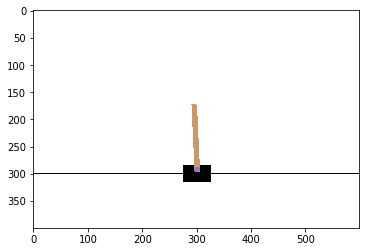

In [87]:
plt.imshow(env.render('rgb_array'))

1.0
False
1.0
False
1.0
False
1.0
False
1.0
False
1.0
False
1.0
False
1.0
False
1.0
False
1.0
False


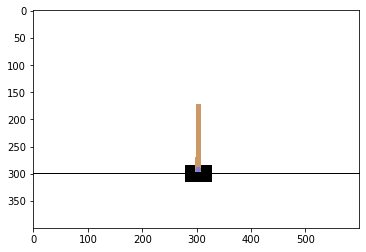

In [113]:
import time
obs=torch.FloatTensor(env.reset())
sm=n.Softmax(dim=1)
for i in range(10):
  actionscalar=(net1.forward(obs)).data.numpy()
  action=int(np.argmax(actionscalar))
  #print(action)
  #dnfsjnf
  obs,reward,isdone,_=env.step(action)
  obs=torch.FloatTensor(obs)
  print(reward)
  print(isdone)
  if isdone:
    obs=torch.FloatTensor(env.reset())
  plt.imshow(env.render("rgb_array"))
  time.sleep(1)

In [106]:
sm=n.Softmax()
obs=env.reset()
print(net1.forward(torch.FloatTensor(obs)).data.numpy())


[0.13524394 0.00174135]


In [98]:
actprob.

Softmax(dim=tensor([ 0.1656, -0.0202], grad_fn=<AddBackward0>))